In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

# import missingno as msno
from scipy import stats
from sklearn import preprocessing
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')
SEED = 42

Load data and prepare it

In [3]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:1459], all_data.loc[1460:]

df_train=pd .read_csv('D:/Course ML/Housing price/train.csv')

y_train = df_train.SalePrice
id_val = df_train.Id
df_test=pd.read_csv('D:/Course ML/Housing price/test.csv')
all_data = concat_df(df_train, df_test).drop(['SalePrice', 'Id'], axis=1)
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


Data analysis, 
lets go to see the cprelation between features and the target features '" SalePrice"


<AxesSubplot:>

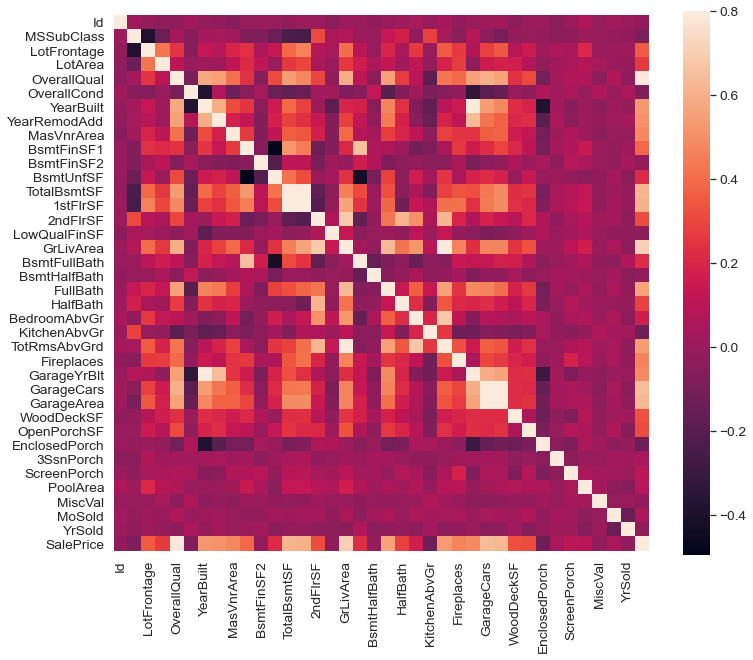

In [5]:
cor_matrix=df_train.corr()
f, ax=plt.subplots(figsize=(12, 10))
sns.heatmap(cor_matrix, vmax=0.8, square=True)

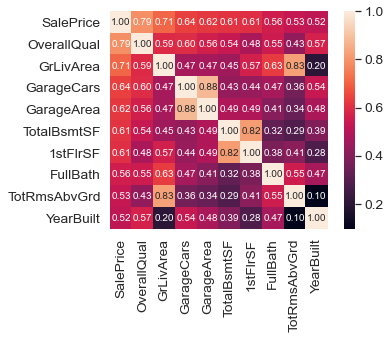

In [6]:
# Let get the best 10 features corelated with saleprice
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = cor_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)

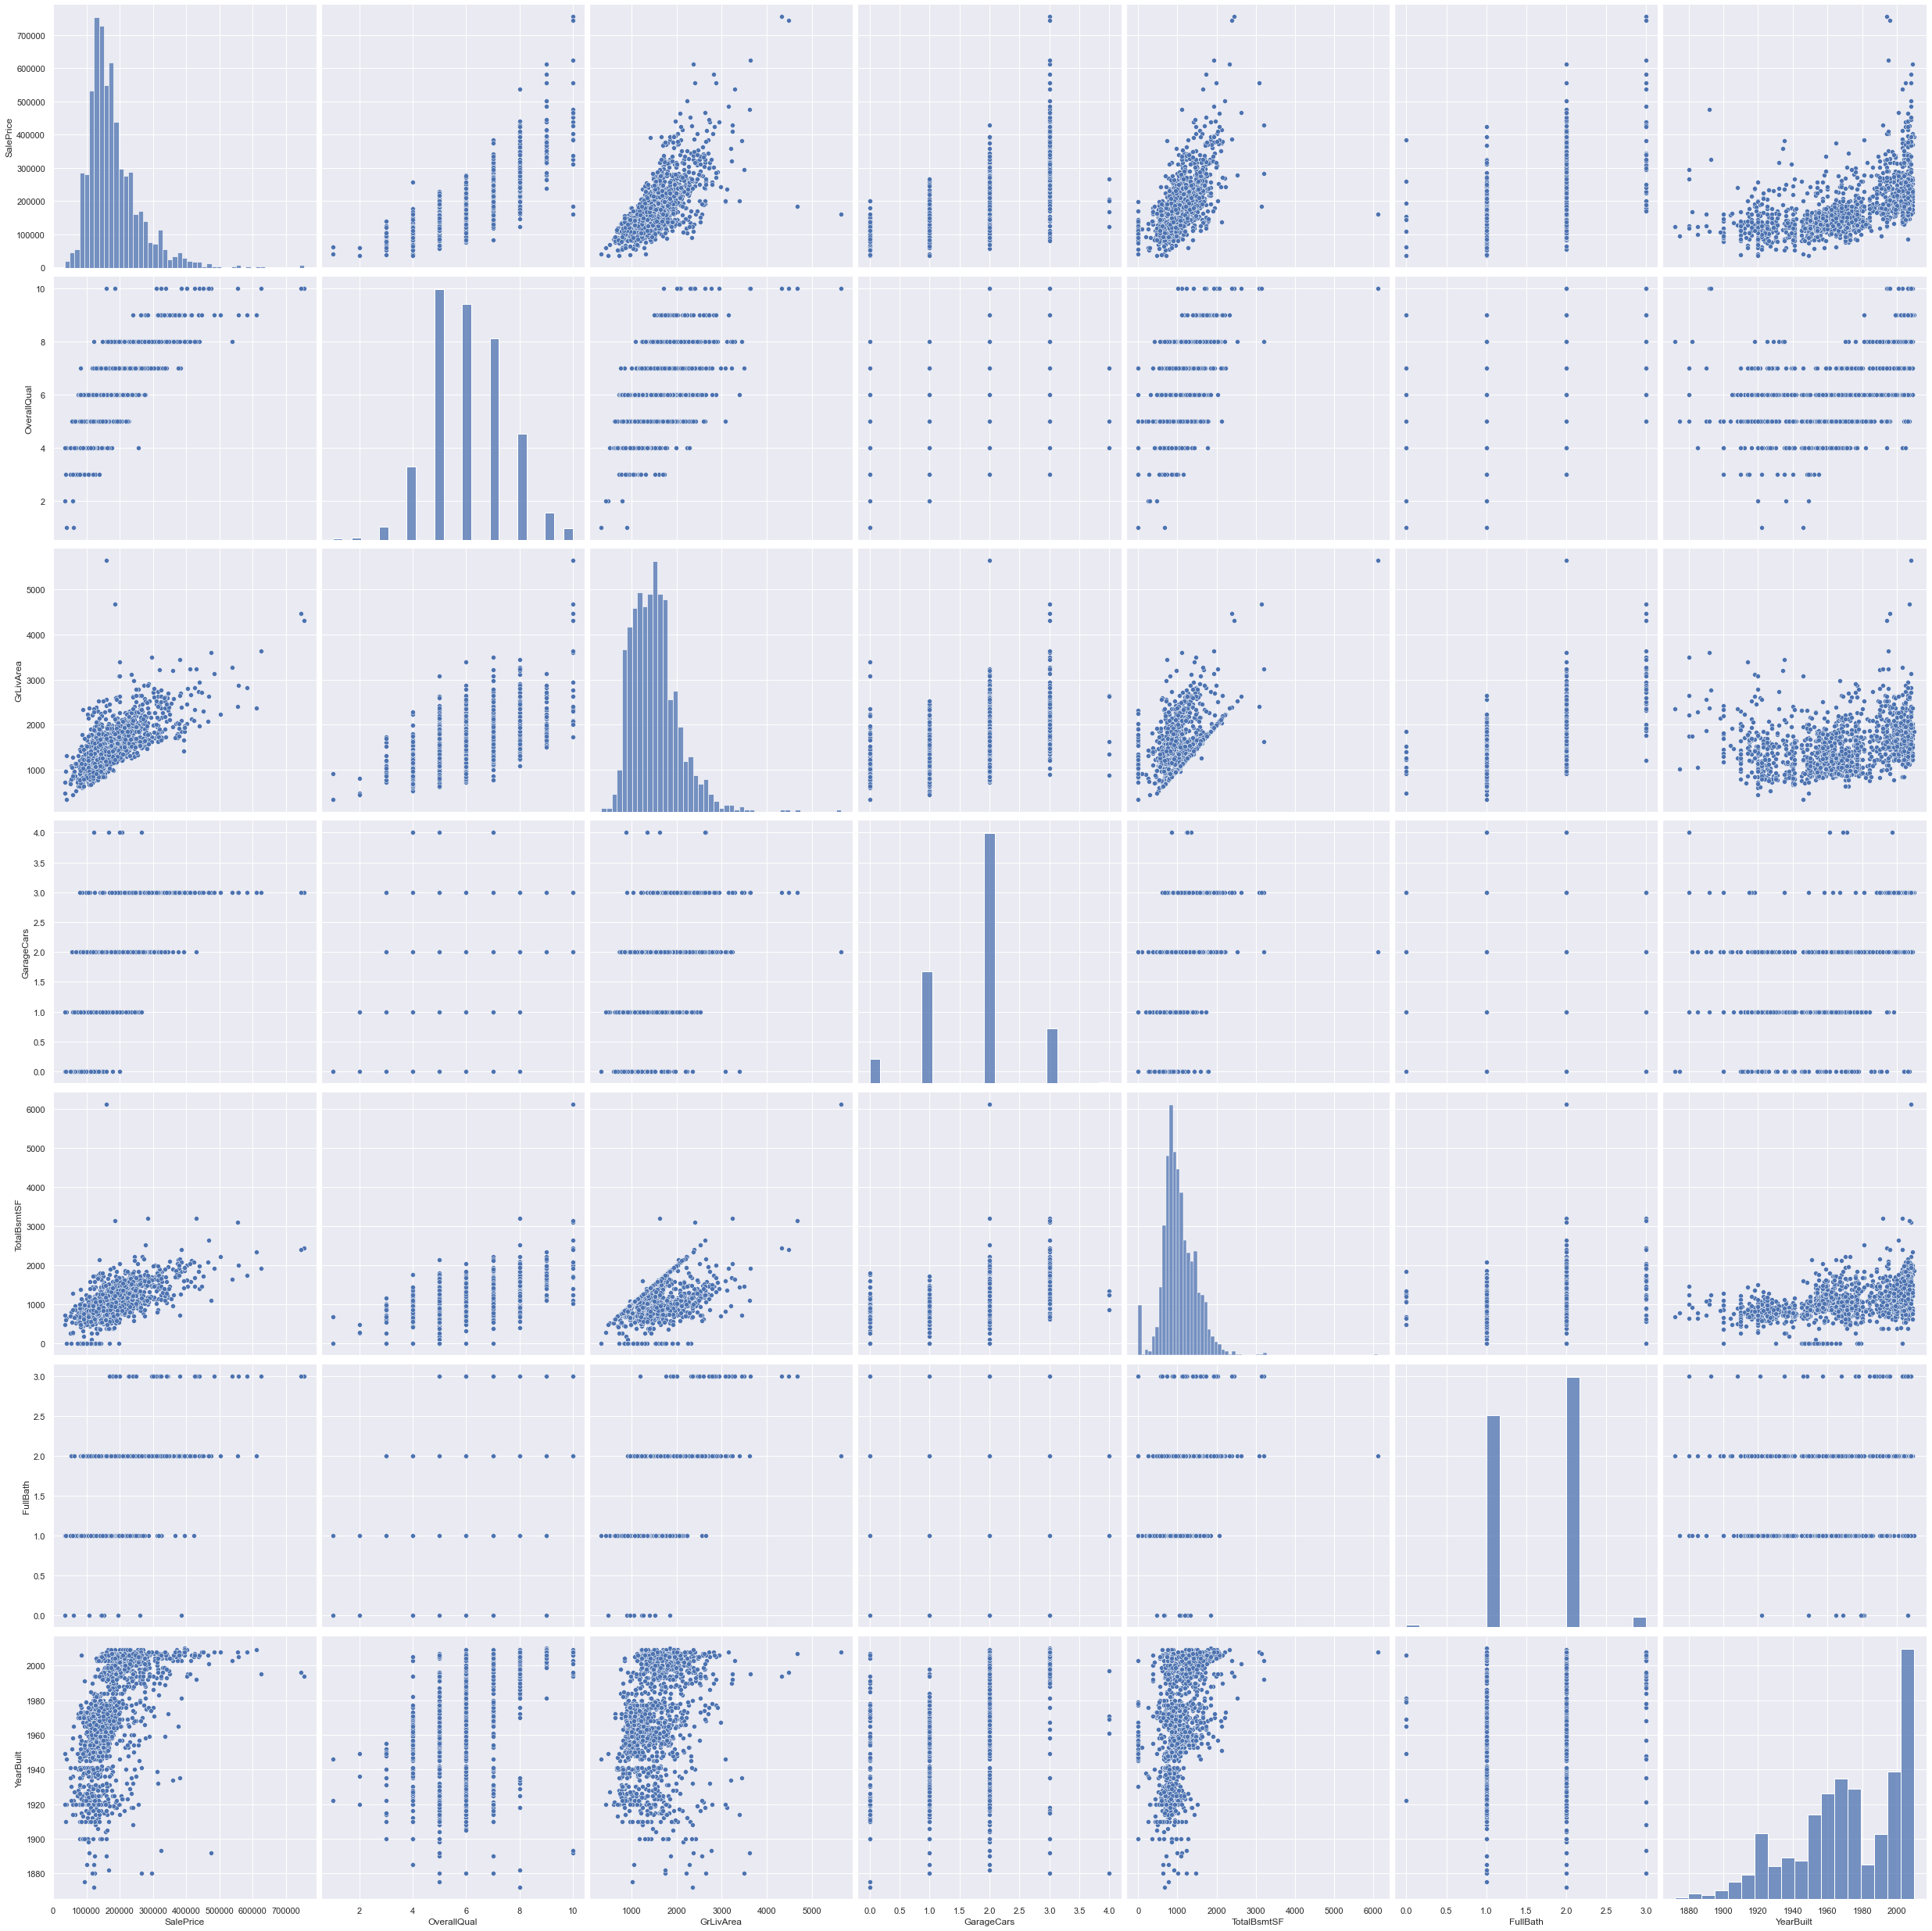

In [7]:
'''
look ! 
this features is the best features related to saleprice>>

['GarageCars', 'GarageArea', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'FullBath']
so we will focus on this features
'''
sns.set()
columns=['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[columns], size=5)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


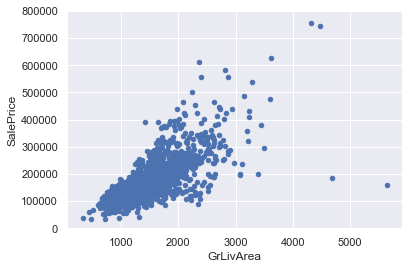

In [8]:
# we notice that GrlivArea contain outliers so we will deal with it.
# Scatter plot GrLivArea/SalePrice
data=pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000))
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

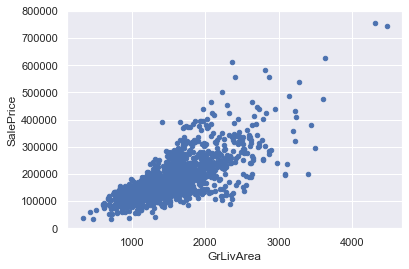

In [9]:
# Deleting outliers
data=data.drop(df_train[(data['GrLivArea']>4000) & (data['SalePrice']<300000)].index)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

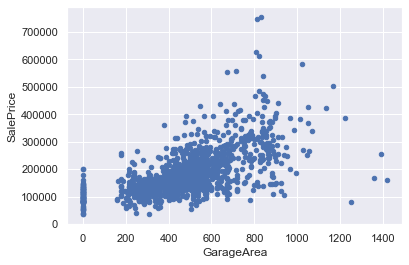

In [10]:

# Seems that the relationship between GarageArea/SalePrice is strong
data=pd.concat([df_train['SalePrice'], df_train['GarageArea']], axis=1)
data.plot.scatter(x='GarageArea', y='SalePrice')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

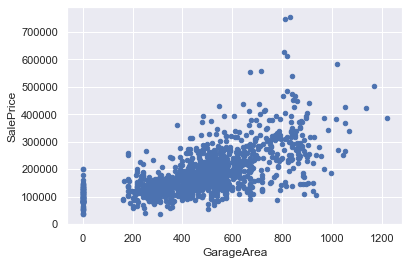

In [11]:
# Deleting outliers
data=data.drop(df_train[(data['GarageArea']>1200) & (data['SalePrice']<300000)].index)
data.plot.scatter(x='GarageArea', y='SalePrice')

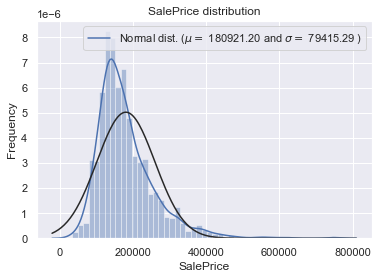

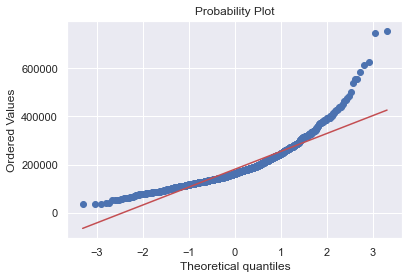

In [12]:
# Now we will deal with target varaible 'SalePrice'
df_train['SalePrice'].describe()

# client don't understand this number so we must send a picture
# histogram
sns.distplot(df_train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

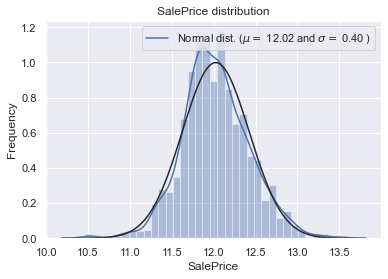

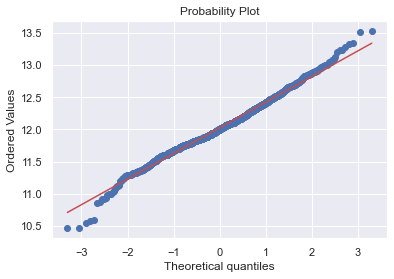

In [13]:
'''
As (linear) models love normally distributed data 
we need to transform this variable and make it more normally distributed.
Log-transformation of the target variable

We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
'''
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
# We will check new distribution 
sns.distplot(df_train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)


In [15]:
# Missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageCond,5.447071
GarageQual,5.447071
GarageYrBlt,5.447071
GarageFinish,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

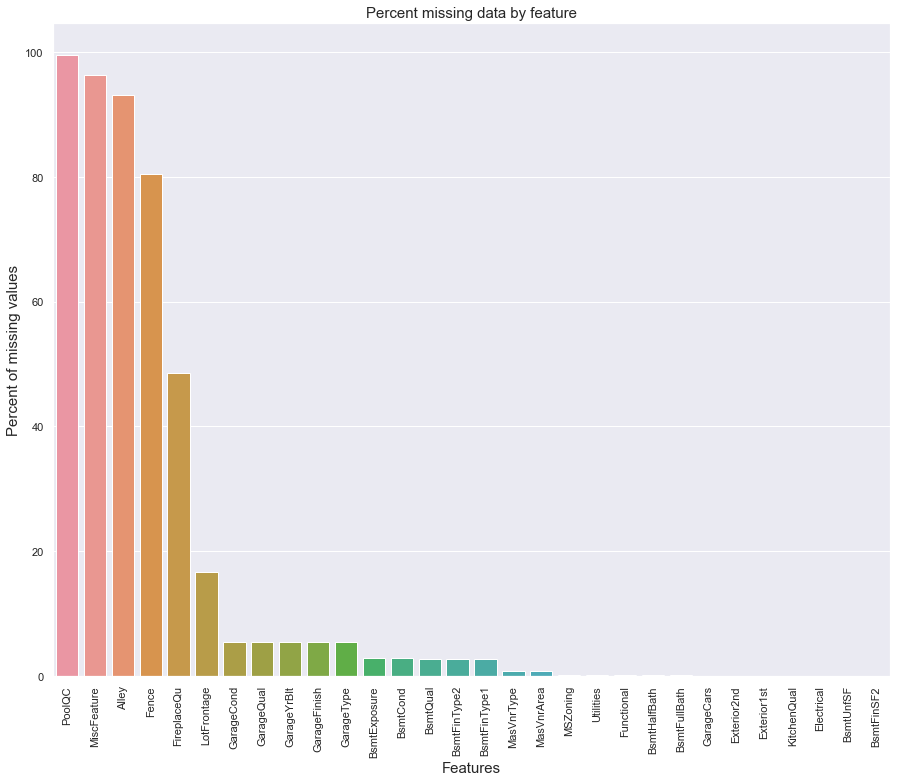

In [16]:
#Barblot of missing data 
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


Dealing with missing data

In [17]:
null_features = all_data.isnull().sum()

# For features having smaller than 100 missing values
null_100 = all_data.columns[list((null_features < 100) & (null_features != 0))]
num = all_data[null_100].select_dtypes(include=np.number).columns
non_num = all_data[null_100].select_dtypes(include='object').columns
# Numerous features --> Fill with their median
all_data[num] = all_data[num].apply(lambda x: x.fillna(x.median()))
# Object features --> Fill with value having the highest frequently in this feature
all_data[non_num] = all_data[non_num].apply(lambda x: x.fillna(x.value_counts().index[0]))

# For features having larger than 1000 missing values --> I drop them
null_1000 = all_data.columns[list(null_features > 1000)]
all_data.drop(null_1000, axis=1, inplace=True)
all_data.drop(['GarageYrBlt', 'LotFrontage'], axis=1, inplace=True)

# For other features having missing values --> Fill na value with "Null" 
# GarageCond
all_data['GarageCond'] = all_data['GarageCond'].fillna('Null')
# GarageFinish
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('Null')
# GarageQual
all_data['GarageQual'] = all_data['GarageQual'].fillna('Null')
# GarageType
all_data['GarageType'] = all_data['GarageType'].fillna('Null')


df_train, df_test = divide_df(all_data)
df_train = pd.concat([df_train, y_train], axis=1)  # Concatenate for analysis

# Checking existing missing value or not
print(all_data.isnull().any().sum())


0


Feature engineering

In [18]:
# Using binned technique for "YearBuilt", "YearRemodAdd" & "YrSold"
all_data['YearBuilt'] = pd.qcut(all_data['YearBuilt'], 10, duplicates='drop')
all_data['YearRemodAdd'] = pd.qcut(all_data['YearRemodAdd'], 10, duplicates='drop')
all_data['YrSold'] = pd.qcut(all_data['YrSold'], 10, duplicates='drop')



# Encode categorical features to numeric feature
for cate_col in ['YearBuilt', 'YearRemodAdd', 'YrSold']:
    all_data[cate_col] = preprocessing.LabelEncoder().fit_transform(all_data[cate_col].values)
    
df_train, df_test = divide_df(all_data)


34


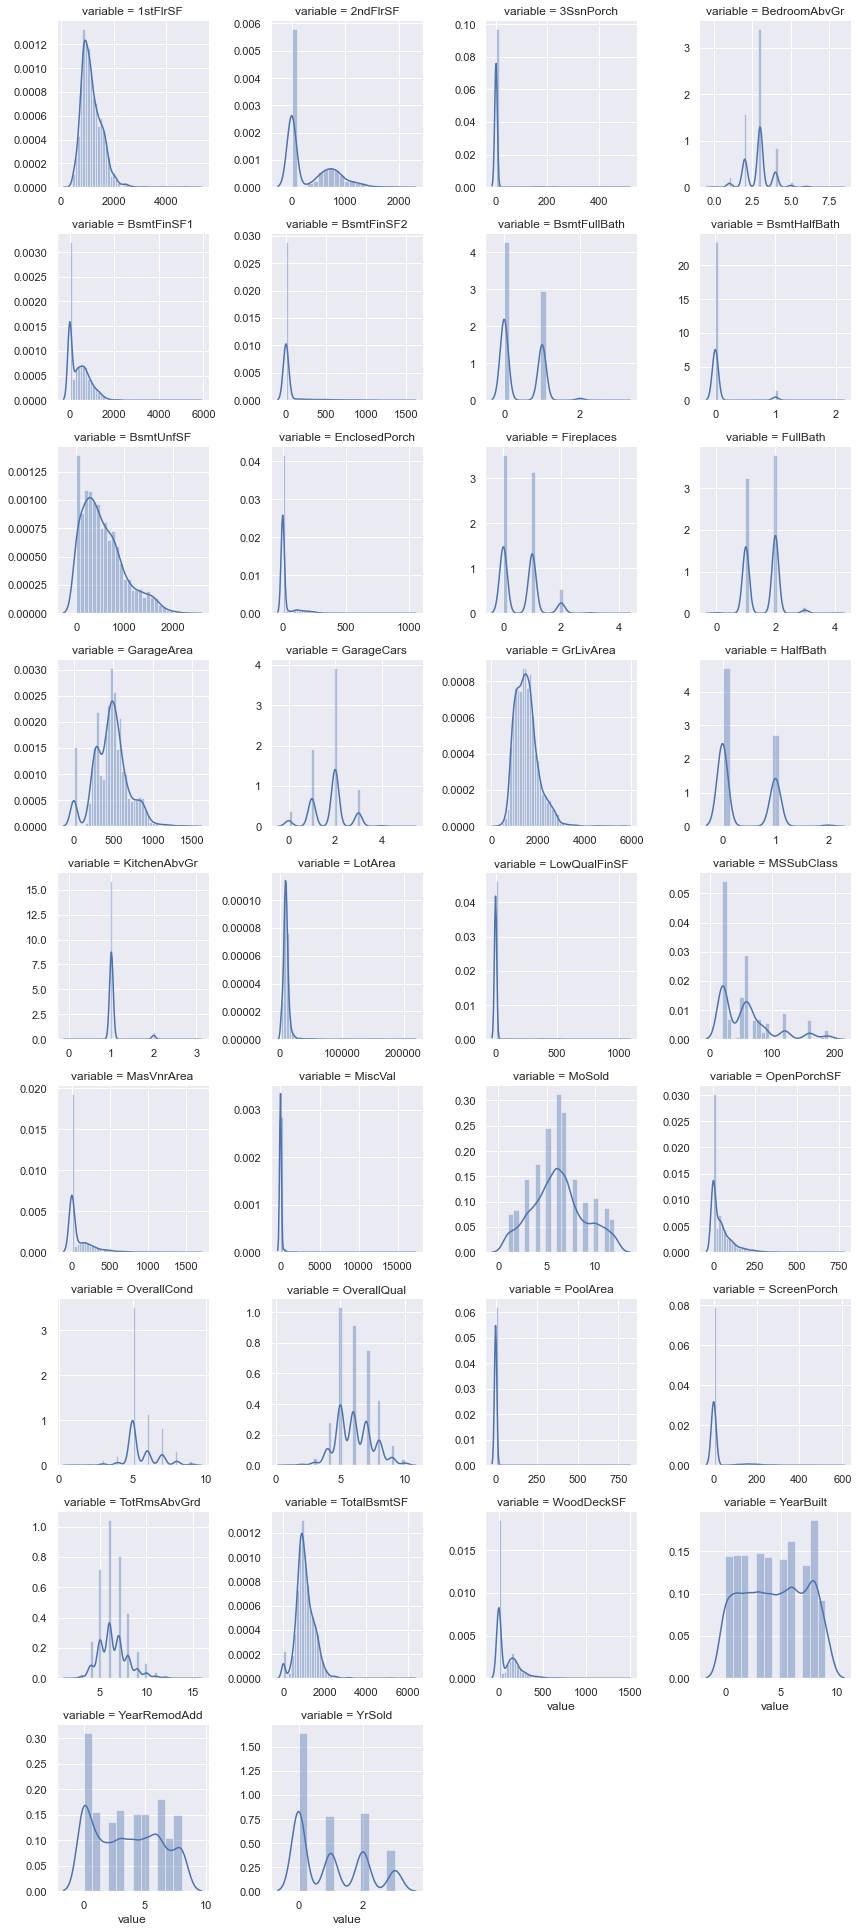

In [19]:
# Numeric data

# finding numerical features
numric_data=all_data.select_dtypes(include=[np.number])
print(numric_data.shape[1])

# Distribution of numerical features
f=pd.melt(all_data, value_vars=sorted(numric_data))
g=sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g=g.map(sns.distplot, 'value')

In [20]:
# Total square feet of porch in a house
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                          all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# Total number of bathroom
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                       all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
# House having the fire place or not
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
# Total number of bathroom in basement
all_data['TotalBsmtbath'] = all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])
# Total square foot
all_data['TotalSF'] = all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


In [21]:

# These columns are used for generating above new features --> Drop the old features
all_data.drop(['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF', 'FullBath', 'HalfBath',
            'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)



num_features = ['OverallQual', 'GrLivArea', 'TotalSF', 'GarageCars', 'TotalBath', 'GarageArea', 'TotalBsmtSF',
 '1stFlrSF', 'TotRmsAbvGrd', 'MasVnrArea', 'HasFireplace', 'Fireplaces', 'TotalPorchSF', '2ndFlrSF',
 'LotArea', 'HasGarage', 'TotalBsmtbath', 'BsmtUnfSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']

# Drop the unused numeric columns also
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = all_data.select_dtypes(include=numeric_dtypes).columns
drop_num = np.setdiff1d(num_cols, num_features)

all_data.drop(drop_num, axis=1, inplace=True)

In [22]:
# Normalize skewness feature using Log function
skew_features = all_data[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.5]
print(skew_features) 

LotArea          12.822431
MasVnrArea        2.613592
TotalSF           1.835745
1stFlrSF          1.469604
TotalPorchSF      1.376649
GrLivArea         1.269358
TotalBsmtSF       1.162616
BsmtUnfSF         0.919703
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
YrSold            0.566501
TotalBsmtbath     0.550351
HasGarage        -3.955907
dtype: float64


In [23]:
# Apply Box cox for skewness > 0.75
for feat in skew_features.index:
    all_data[feat] = np.log1p(all_data[feat])

df_train, df_test = divide_df(all_data)

df_train[num_features].head()

,OverallQual,GrLivArea,TotalSF,GarageCars,TotalBath,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,MasVnrArea,...,Fireplaces,TotalPorchSF,2ndFlrSF,LotArea,HasGarage,TotalBsmtbath,BsmtUnfSF,YearBuilt,YearRemodAdd,YrSold
0,7,7.444833,7.790282,2.0,3.5,548.0,6.753438,6.753438,2.197225,5.283204,...,0.000000,4.127134,6.751101,9.042040,0.693147,0.693147,5.017280,7,6,0.693147
1,6,7.141245,7.714677,2.0,2.5,460.0,7.141245,7.141245,1.945910,0.000000,...,0.693147,5.700444,0.000000,9.169623,0.693147,0.405465,5.652489,5,2,0.000000
2,7,7.488294,7.728856,2.0,3.5,608.0,6.825460,6.825460,1.945910,5.093750,...,0.693147,3.761200,6.765039,9.328212,0.693147,0.693147,6.075346,7,5,0.693147
3,7,7.448916,7.567346,3.0,2.0,642.0,6.629363,6.869014,2.079442,0.000000,...,0.693147,5.730100,6.629363,9.164401,0.693147,0.693147,6.293419,0,1,0.000000
4,8,7.695758,7.956477,3.0,3.5,836.0,7.044033,7.044033,2.302585,5.860786,...,0.693147,5.624018,6.960348,9.565284,0.693147,0.693147,6.196444,7,5,0.693147


2919


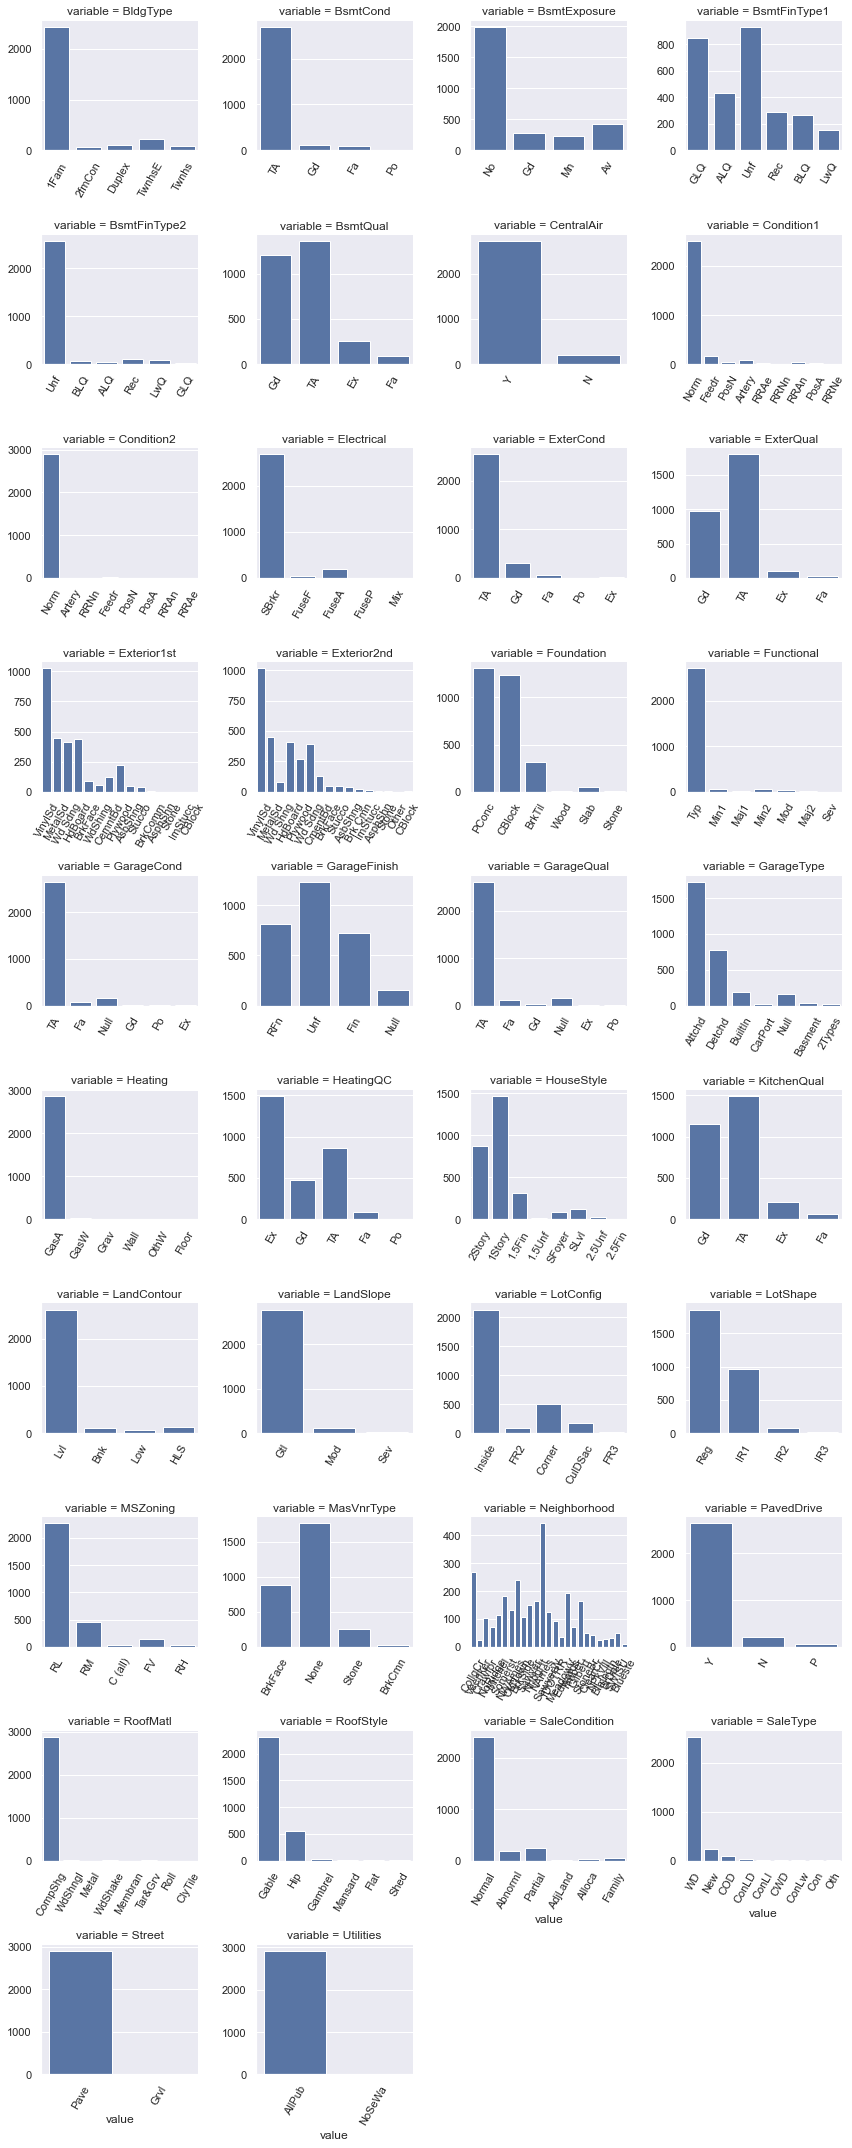

2919

In [24]:
# Categorical features

# finding categorical features
categorical_data=all_data.select_dtypes(exclude=[np.number])
print(categorical_data.shape[0])

# Let's plot count of categorical features
f=pd.melt(all_data, value_vars=sorted(categorical_data))
g=sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g=g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()
categorical_data.shape[0]

In [25]:
# Some features having some values exist in training dataset but not in testing dataset --> Fix it

# "Electrical" features
df_train['Electrical'].loc[df_train['Electrical']=='Mix'] = 'SBrkr'
# "Exterior2nd" features
df_train['Exterior2nd'].loc[df_train['Exterior2nd']=='Other'] = 'VinylSd'
# "Heating" features
df_train['Heating'].loc[df_train['Heating']=='OthW'] = 'GasA'
df_train['Heating'].loc[df_train['Heating']=='Floor'] = 'GasA'
# "HouseStyle" features
df_train['HouseStyle'].loc[df_train['HouseStyle']=='2.5Fin'] = '1.5Fin'

# Choosing the appropriate categorical features
cate_features = ['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'Condition1', 'Electrical',
 'ExterCond', 'ExterQual', 'Exterior2nd', 'Functional', 'GarageCond', 'GarageType', 'Heating', 'HouseStyle',
 'KitchenQual', 'LandContour', 'LandSlope', 'LotShape', 'Neighborhood', 'PavedDrive', 'RoofStyle',
 'SaleCondition', 'SaleType', 'Street', 'YearBuilt', 'YearRemodAdd', 'YrSold']

# Drop the unused categorical columns by choosing the only set of columns above
cols = df_train.select_dtypes(exclude=[np.number]).columns
# Choose features only in "cols" but not in "cate_features"
drop_cate = np.setdiff1d(cols, cate_features)

df_train.drop(drop_cate, axis=1, inplace=True)
df_test.drop(drop_cate, axis=1, inplace=True)

# Encode the categorical features by using One-hot encoding technique
print(df_train.shape, df_test.shape)
print(df_test.shape)
# Transform categorical feature to dummies features
encoded_features = list()

for df in [df_train, df_test]:
    for feature in cate_features:
        # Change to array after encoding b.c want to add columns when change back to df
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        # "n": Number of unique value in each feature
        n = df[feature].nunique()
        # "feature_uniqueVal" are the col's names in df after One-hot encoding
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:len(cate_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(cate_features):]], axis=1)
print(df_train.shape, df_test.shape)

# Drop original category features
df_train.drop(cate_features, axis=1, inplace=True)
df_test.drop(cate_features, axis=1, inplace=True)

all_data = concat_df(df_train, df_test)

print(df_train.shape, df_test.shape)

(1460, 46) (1459, 46)
(1459, 46)
(1460, 224) (1459, 224)
(1460, 196) (1459, 196)


Modeling

In [26]:
from sklearn.model_selection import KFold # for repeated K-fold cross validation
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score # score evaluation

In [27]:
# Repeated K-fold cross validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Return root mean square error applied cross validation (Used for training prediction)
def evaluate_model_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)
# Base model
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7, verbosity = 0,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, seed=SEED, reg_alpha=0.00006)
# Training model & find root mean square error (With cross validation technqiue)
xgboost = xgboost.fit(np.array(df_train), np.array(y_train))
print('Finish training')
cv_rmse_result = evaluate_model_cv(xgboost, np.array(df_train), np.array(y_train))
print(f'xgboost\'s rmse (apply cv) after training: {np.mean(cv_rmse_result)}\n')

Finish training
xgboost's rmse (apply cv) after training: 24882.44698674618



Create the submission

In [28]:
# Testing ID
test = pd.read_csv('D:/Course ML/Housing price/test.csv')
test_id = test['Id']

# When normalize the target
submit = pd.concat((test_id, 
                    pd.Series(xgboost.predict(np.array(df_test)), name='SalePrice')), axis=1)
submit.to_csv('Submission.csv', index=False)